In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm
import matplotlib as mpl
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import warnings
# Filter out specific ValueWarnings from statsmodels
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [3]:
pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


# Reading Data

In [4]:
client = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\client.csv")

In [5]:
hist_weather = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\historical_weather.csv")

In [6]:
data = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\train.csv")

In [7]:
forecast_weather = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\forecast_weather.csv")

In [8]:
electricity = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\electricity_prices.csv")

In [9]:
gas = pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\gas_prices.csv")

In [10]:
# it would be used instead of df_station_to_county.county_name
locations=pd.read_csv(r"C:\Users\mrdel\Desktop\BootCamp\Capstone Project\Capstone Datasets\predict-energy-behavior-of-prosumers\county_lon_lats.csv")

# Feature Engineering

# Function: preTrain

## Purpose
This function prepares and pre-processes various datasets for training a machine learning model. It performs several data cleaning, merging, and feature engineering steps.

## Input Parameters
- `data`: Main dataset containing the target variable.
- `client`: Client data.
- `hist_weather`: Historical weather data.
- `forecast_weather`: Forecasted weather data.
- `electricity`: Electricity data.
- `gas`: Gas data.
- `locations`: Custom data containing latitude, longitude, and county information.

## Steps

1. **Drop NaN values in the target variable (`data['target']`).**
2. **Convert the 'datetime' column in `data` to datetime format.**
3. **Rename and convert the 'forecast_date' column in `electricity` to datetime format.**
4. **Adjust the 'data_block_id' in `client` by subtracting 2.**
5. **Clean and process the 'locations' data.**
6. **Round latitude and longitude in `forecast_weather` to 1 decimal fraction.**
7. **Merge county information from `locations` into `forecast_weather`.**
8. **Drop unnecessary columns in `forecast_weather` and rename 'forecast_datetime' to 'datetime'.**
9. **Group `forecast_weather` columns by hour, calculating mean values for each hour.**
10. **Round latitude and longitude in `hist_weather` to 1 decimal fraction.**
11. **Merge county information from `locations` into `hist_weather`.**
12. **Drop unnecessary columns in `hist_weather`.**
13. **Group `hist_weather` columns by hour, calculating mean values for each hour.**
14. **Merge `data_block_id` back into `hist_weather` after the groupby operation.**
15. **Add new temporal features (year, month, day, hour, dayofweek, dayofyear) to `data`.**
16. **Add 'hour' column to `electricity` for merging with `data`.**
17. **Merge `client`, `gas`, `electricity`, `forecast_weather` datasets into `data`.**
18. **Merge aggregated forecast weather data (`forecast_weather_datetime`) into `data`.**
19. **Merge aggregated forecast weather data by county (`forecast_weather_datetime_county`) into `data`.**
20. **Create 'hour' columns in both historical weather datasets.**
21. **Drop duplicates and 'datetime' column in historical weather datasets.**
22. **Merge aggregated historical weather data (`hist_weather_datetime`) into `data`.**
23. **Merge aggregated historical weather data by county (`hist_weather_datetime_county`) into `data`.**
24. **Fill NaN values in `data` using forward fill and backward fill within each group (year, day, hour).**
25. **Drop unnecessary columns in `data`.**
26. **Return the preprocessed `data` for model training.**


In [11]:
def preTrain(data, client, hist_weather,
               forecast_weather, electricity, gas, locations):
    
    #Dropping (target) nan values
    data= data[data['target'].notnull()] 
    #Converting (datetime) column to datetime
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
    #Renaming (forecast_date) to (datetime) for merging with the train data later
    electricity = electricity.rename(columns= {'forecast_date' : 'datetime'})
    #Converting (datetime) column to datetime
    electricity['datetime'] = pd.to_datetime(electricity['datetime'], utc= True)
    #Decreasing (data_block_id) in client data because it's 2 steps ahead from train's data (data_block_id)
    client['data_block_id'] -= 2
      
    """locations is a custom data that will help replace (latitude) and (longitude)
    columns by the counties for each coordination | you can find the data in Input """
    locations = locations.drop('Unnamed: 0', axis= 1) 
        
    #Rounding the (latitude) and (longitude) for 1 decimal fraction
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude',
                                                                    'longitude']].astype(float).round(1)
    #Merging counties in locations data with the coordinations in the forecast_weather data
    forecast_weather= forecast_weather.merge(locations, how='left',
                                             on=['longitude','latitude'])
    #dropping nan values
    forecast_weather.dropna(axis= 0, inplace= True)    
    #Converting (county) column to integer
    forecast_weather['county'] = forecast_weather['county'].astype('int64')
    #Dropping the columns we won't need | We will use the (forecast_datetime) column instead of the (origin_datetime)
    forecast_weather.drop(['origin_datetime', 'latitude',
                           'longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace= True)
    #Renaming (forecast_datetime) to (datetime) for merging with the train data later
    forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace= True)
    #Converting (datetime) column to datetime
    forecast_weather['datetime']= pd.to_datetime(forecast_weather['datetime'], utc= True)
    """Grouping all forecast_weather columns mean values by hour, So each hour
    will have the mean values of the forecast_weather columns""" 
    forecast_weather_datetime= forecast_weather.groupby([forecast_weather['datetime'].
                                            dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                                            'datetime'], axis= 1)
                                                                     .columns)].mean().reset_index()
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime['datetime']= pd.to_datetime(
        forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    """Grouping all forecast_weather columns mean values by hour and county, So each hour and county
    will have the mean values of the forecast_weather columns for each county""" 
    forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].
                              dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                              'datetime'], axis= 1)
                                                       .columns)].mean().reset_index()
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime_county['datetime']= pd.to_datetime(
        forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)

    #Rounding the (latitude) and (longitude) for 1 decimal fraction           
    hist_weather[['latitude', 'longitude']] = hist_weather[['latitude', 'longitude']].astype(float).round(1)

    #Merging counties in locations data with the coordinations in the historical_weather data
    hist_weather= hist_weather.merge(locations, how='left', on=['longitude','latitude'])    
    #Dropping nan values
    hist_weather.dropna(axis= 0, inplace= True)
    #Dropping the columns we won't need
    hist_weather.drop(['latitude', 'longitude'], axis=1, inplace= True)
    #Converting (county) to integer
    hist_weather['county'] = hist_weather['county'].astype('int64')
    #Converting (datetime) column to datetime
    hist_weather['datetime']= pd.to_datetime(hist_weather['datetime'], utc= True)
    
    """Grouping all historical_weather columns mean values by hour, So each hour
    will have the mean values of the historical_weather columns"""     
    hist_weather_datetime= hist_weather.groupby([hist_weather['datetime'].
                                            dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                                            'datetime',
                                                                                        'data_block_id'], axis= 1)
                                                                     .columns)].mean().reset_index()    
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime['datetime']= pd.to_datetime(
        hist_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    #Merging (data_block_id) back after dropping it in the last step | (data_block_id will be used to merge with train data)
    hist_weather_datetime= hist_weather_datetime.merge(
        hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    """Grouping all historical_weather columns mean values by hour and county, So each hour
    will have the mean values of the historical_weather columns for each county"""   
    hist_weather_datetime_county= hist_weather.groupby(['county',hist_weather['datetime'].
                              dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                              'datetime', 'data_block_id'], axis= 1)
                                                       .columns)].mean().reset_index() 
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime_county['datetime']= pd.to_datetime(
        hist_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)
    #Merging (data_block_id) back after dropping it in the last step
    hist_weather_datetime_county= hist_weather_datetime_county.merge(
        hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    #Adding year column in train data
    data['year'] = data['datetime'].dt.year
    #Adding month column in train data
    data['month'] = data['datetime'].dt.month
    #Adding day column in train data
    data['day'] = data['datetime'].dt.day
    #Adding hour column in train data
    data['hour'] = data['datetime'].dt.hour
    #Adding dayofweek column in train data
    data['dayofweek'] = data['datetime'].dt.dayofweek
    #Adding dayofyear column in train data
    data['dayofyear']= data['datetime'].dt.dayofyear
    #Adding hour column to electricity used to merge with the train data
    electricity['hour'] = electricity['datetime'].dt.hour
    #Merging train data with client data
    data= data.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])
    
    #Merging train data with gas data
    data= data.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    #Merging train data with electricity data    
    data= data.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])
    
    #Merging train data with forecast_weather_datetime data    
    data= data.merge(forecast_weather_datetime, how='left', on=['datetime'])
    
    #Merging train data with forecast_weather_datetime_county data    
    data= data.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'],
                     suffixes= ('_fcast_mean','_fcast_mean_by_county'))
    
    #Creating hour columns in both historical_weather data | used to merge both data with the train data
    hist_weather_datetime['hour']= hist_weather_datetime['datetime'].dt.hour
    hist_weather_datetime_county['hour']= hist_weather_datetime_county['datetime'].dt.hour

    #Dropping duplicates and (datetime) column
    hist_weather_datetime.drop_duplicates(inplace=True)
    hist_weather_datetime_county.drop_duplicates(inplace=True)
    hist_weather_datetime.drop('datetime', axis= 1, inplace= True)
    hist_weather_datetime_county.drop('datetime', axis= 1, inplace= True)

    #Merging hist_weather_datetime with train data
    data= data.merge(hist_weather_datetime, how='left', on=['data_block_id', 'hour'])


    #Merging hist_weather_datetime_county with train data
    data= data.merge(hist_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'],
                     suffixes= ('_hist_mean','_hist_mean_by_county'))

    #Filling nan values with hourly mean values for each column | Helps for the county missing value 
    data= data.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()
    
    #Dropping uneeded data
    data.drop(['level_0', 'level_1', 'row_id', 'data_block_id', 'year'], axis= 1, inplace= True)
    return data

In [ ]:
def create_revealed_targets_train(data, N_day_lags):
    '''Creating lagged target values | A target value depends on what was a target value n days ago'''
    
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    #Create revealed targets for n days lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

# Function: create_revealed_targets_train

## Purpose
This function is designed to create lagged target values for a given dataset. It generates new columns in the dataset representing the target values from N days ago for each prediction unit and consumption type.

## Input Parameters
- `data`: The main dataset containing the target variable.
- `N_day_lags`: The number of days for which lagged target values should be created.

## Steps

1. **Create a copy of the columns 'datetime', 'prediction_unit_id', 'is_consumption', and 'target' from the original dataset (`data`).**
2. **Iterate over each day lag from 2 to `N_day_lags`.**
    - a. **Create a new 'datetime' column by adding a DateOffset of the current day lag to the original datetime values.**
    - b. **Merge the original dataset (`data`) with the revealed targets dataset using the new 'datetime', 'prediction_unit_id', and 'is_consumption' columns.**
    - c. **Suffix the newly created columns with the corresponding day lag, indicating how many days ago the target values were.**

## Output
The function returns the modified dataset (`data`) with additional columns representing the lagged target values for each specified day lag.



In [13]:
def get_agg_target_lag(df):
    
    tgt_lag_columns = [c for c in df.columns if '_days_ago' in c]
    
    for m in ['mean', 'std', 'var', 'median', 'max', 'min']:
        df[f'target_{m}'] = df[tgt_lag_columns].agg(m, axis=1)
        
    return df

# Function: get_agg_target_lag

## Purpose
This function is designed to aggregate lagged target values in a DataFrame and compute various statistics (mean, standard deviation, variance, median, maximum, minimum) for each row based on the lagged values.

## Input Parameters
- `df`: The DataFrame containing lagged target values.

## Steps

1. **Identify columns in the DataFrame that represent lagged target values (`_days_ago` in column names).**
    - a. **Store these columns in the list `tgt_lag_columns`.**
    
2. **Iterate over different aggregation methods (`mean`, `std`, `var`, `median`, `max`, `min`).**
    - a. **For each aggregation method (`m`), compute the corresponding statistic for each row across lagged target columns using `agg` along the specified axis (axis=1).**
    - b. **Create new columns in the DataFrame with names like `target_mean`, `target_std`, etc., containing the computed values.**

## Output
The function returns the DataFrame (`df`) with additional columns representing aggregated statistics for lagged target values.



In [14]:
#Applying the Train function and storing our train data in the (train) variable
train= preTrain(data, client, hist_weather, forecast_weather, electricity, gas, locations)
#Specify how many days to lag and applying the function
N_day_lags = 7
train = create_revealed_targets_train(train, N_day_lags = N_day_lags)
train['datetime'] = train['datetime'].astype('int64')

In [15]:
train.head(100)

,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,month,day,hour,...,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago
0,0,0,1,0.713,0,1630454400000000000,0,9,1,0,...,143.6,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,1630454400000000000,0,9,1,0,...,143.6,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,1630454400000000000,1,9,1,0,...,143.6,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,1630454400000000000,1,9,1,0,...,143.6,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,1630454400000000000,2,9,1,0,...,143.6,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11,1,2,26.553,1,1630454400000000000,47,9,1,0,...,143.6,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
96,11,1,3,0.076,0,1630454400000000000,48,9,1,0,...,143.6,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
97,11,1,3,3717.859,1,1630454400000000000,48,9,1,0,...,143.6,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
98,12,1,3,0.000,0,1630454400000000000,49,9,1,0,...,143.6,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#Data transformation
train['sin_hour']= (np.pi * np.sin(train['hour']) / 12)
train['cos_hour']= (np.pi * np.cos(train['hour']) / 12)
train['sin_dayofyear']= (np.pi * np.sin(train['dayofyear']) / 183)
train['cos_dayofyear']= (np.pi * np.cos(train['dayofyear']) / 183)
train['target_mean']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].mean(1)
train['target_std']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].std(1)
train['target_var']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].var(1)

## Purpose
This code segment performs additional data transformation on the `train` dataset. The transformations include:

- **Sin and Cosine Transformations for 'hour' and 'dayofyear':**
  - `sin_hour`: Computes the sine transformation for the 'hour' column.
  - `cos_hour`: Computes the cosine transformation for the 'hour' column.
  - `sin_dayofyear`: Computes the sine transformation for the 'dayofyear' column.
  - `cos_dayofyear`: Computes the cosine transformation for the 'dayofyear' column.

- **Aggregations for Lagged Target Values:**
  - `target_mean`: Computes the mean of lagged target values for each row.
  - `target_std`: Computes the standard deviation of lagged target values for each row.
  - `target_var`: Computes the variance of lagged target values for each row.

## Explanation
- Sin and cosine transformations are commonly used to encode cyclical patterns, such as hours in a day or days in a year, into a format that captures their periodic nature.

- The aggregations (`target_mean`, `target_std`, `target_var`) provide summary statistics for lagged target values, summarizing information about the historical target values for each row.

Overall, these transformations aim to create additional features that capture temporal patterns and statistical properties of lagged target values, potentially improving the model's ability to capture underlying patterns in the data.

In [17]:
#Log columns with outliers
to_log= ['installed_capacity', 'euros_per_mwh', 'temperature_fcast_mean', 'dewpoint_fcast_mean',
        'cloudcover_high_fcast_mean', 'cloudcover_low_fcast_mean', 'cloudcover_mid_fcast_mean', 'cloudcover_total_fcast_mean',
        '10_metre_u_wind_component_fcast_mean', '10_metre_v_wind_component_fcast_mean', 'direct_solar_radiation_fcast_mean',
        'snowfall_fcast_mean', 'total_precipitation_fcast_mean', 'temperature_fcast_mean_by_county', 'dewpoint_fcast_mean_by_county',
        'cloudcover_high_fcast_mean_by_county', 'cloudcover_low_fcast_mean_by_county', 'cloudcover_mid_fcast_mean_by_county',
        'cloudcover_total_fcast_mean_by_county', '10_metre_u_wind_component_fcast_mean_by_county', '10_metre_v_wind_component_fcast_mean_by_county',
        'surface_solar_radiation_downwards_fcast_mean_by_county', 'snowfall_fcast_mean_by_county', 'total_precipitation_fcast_mean_by_county',
        'rain_hist_mean', 'snowfall_hist_mean', 'windspeed_10m_hist_mean_by_county', 'target_2_days_ago', 'target_3_days_ago',
        'target_4_days_ago', 'target_5_days_ago', 'target_6_days_ago', 'target_7_days_ago', 'target_mean', 'target_std']
for i in to_log:
    train[f"log_{i}"]= np.where((train[i])!= 0, np.log(train[i]),0)

In [18]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,month,day,hour,...,log_snowfall_hist_mean,log_windspeed_10m_hist_mean_by_county,log_target_2_days_ago,log_target_3_days_ago,log_target_4_days_ago,log_target_5_days_ago,log_target_6_days_ago,log_target_7_days_ago,log_target_mean,log_target_std
0,0,0,1,0.713,0,1630454400000000000,0,9,1,0,...,0.0,1.414369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,1630454400000000000,0,9,1,0,...,0.0,1.414369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,1630454400000000000,1,9,1,0,...,0.0,1.414369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,1630454400000000000,1,9,1,0,...,0.0,1.414369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,1630454400000000000,2,9,1,0,...,0.0,1.414369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
train.info(verbose= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 117 columns):
 #    Column                                                      Dtype  
---   ------                                                      -----  
 0    county                                                      int64  
 1    is_business                                                 int64  
 2    product_type                                                int64  
 3    target                                                      float64
 4    is_consumption                                              int64  
 5    datetime                                                    int64  
 6    prediction_unit_id                                          int64  
 7    month                                                       int32  
 8    day                                                         int32  
 9    hour                                                        int32 

In [20]:
#Storing training features into numpy arrays
X= train[train['is_consumption'] != 0].drop('target', axis= 1)
y= train[train['is_consumption'] != 0]['target']

#Storing production targets into an array itself | Will seperate it into another model
X2= train[train['is_consumption'] == 0].drop('target', axis= 1).values
y2= train[train['is_consumption'] == 0]['target'].values

In [21]:
#Model 1
Xtr, Xvl, Ytr, Yvl = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=51)


# best_params = {
#     'num_iterations': 4000,
#     'verbose': -1,
#     'objective': 'tweedie',
#     'num_leaves': 455,
#     'learning_rate': 0.03,
#     'colsample_bytree' : 0.92,
#     'colsample_bynode' : 0.45,
#     'reg_alpha'        : 3.62,
#     'reg_lambda'        : 1.65,
#     'min_data_in_leaf': 198,
#     'max_depth': 15,
#     'max_bin': 835
# }


# params from https://www.kaggle.com/code/newtonbaba12345/lb-67-48#Training-models
best_params = {
    'num_iterations': 4000,
    'verbose': -1,
    'objective': 'tweedie',
    'num_leaves': 455,
    'learning_rate': 0.01,
    'colsample_bytree' : 0.92,
    'colsample_bynode' : 0.45,
    'reg_alpha'        : 3.62,
    'reg_lambda'        : 1.65,
    'min_data_in_leaf': 198,
    'max_depth': 20,
}

lgbm= LGBMRegressor(**best_params, random_state= 73)

lgbm.fit(Xtr, Ytr,
        eval_set=[(Xvl, Yvl)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
        ],)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's tweedie: 66.2453
[200]	valid_0's tweedie: 62.2752
[300]	valid_0's tweedie: 61.6085
[400]	valid_0's tweedie: 61.4747
[500]	valid_0's tweedie: 61.4259
[600]	valid_0's tweedie: 61.3933
[700]	valid_0's tweedie: 61.369
[800]	valid_0's tweedie: 61.3514
[900]	valid_0's tweedie: 61.3389
[1000]	valid_0's tweedie: 61.3293
[1100]	valid_0's tweedie: 61.3213
[1200]	valid_0's tweedie: 61.3146
[1300]	valid_0's tweedie: 61.3088
[1400]	valid_0's tweedie: 61.3038
[1500]	valid_0's tweedie: 61.2994
[1600]	valid_0's tweedie: 61.2954
[1700]	valid_0's tweedie: 61.2919
[1800]	valid_0's tweedie: 61.2887
[1900]	valid_0's tweedie: 61.2857
[2000]	valid_0's tweedie: 61.2831
[2100]	valid_0's tweedie: 61.2807
[2200]	valid_0's tweedie: 61.2785
[2300]	valid_0's tweedie: 61.2764
[2400]	valid_0's tweedie: 61.2744
[2500]	valid_0's tweedie: 61.2726
[2600]	valid_0's tweedie: 61.2709
[2700]	valid_0's tweedie: 61.2693
[2800]	valid_0's tweedie: 61.2

LGBMRegressor(colsample_bynode=0.45, colsample_bytree=0.92, learning_rate=0.01,
              max_depth=20, min_data_in_leaf=198, num_iterations=4000,
              num_leaves=455, objective='tweedie', random_state=73,
              reg_alpha=3.62, reg_lambda=1.65, verbose=-1)

In [26]:
#Model 2
Xtr1, Xvl1, Ytr1, Yvl1 = train_test_split(X2, y2, test_size=0.40, shuffle=True,  random_state=51)


best_params = {
        'n_iter'           : 4000,
        'learning_rate': 0.01,
        'max_depth': 13,
        'num_leaves': 455,
        'min_data_in_leaf': 63,
        'min_data_per_groups': 59,
        'verbose'          : -1,
        'objective'        : 'tweedie',
        'colsample_bytree' : 0.89,
        'colsample_bynode' : 0.45,
        'lambda_l1'        : 3.62,
        'lambda_l2'        : 1.65
}


lgbm2= LGBMRegressor(**best_params, random_state= 73)
lgbm2.fit(Xtr1, Ytr1,
        eval_set=[(Xvl1, Yvl1)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=120),
            lgb.callback.log_evaluation(period=120),
        ],)

Training until validation scores don't improve for 120 rounds
[120]	valid_0's tweedie: 22.2253
[240]	valid_0's tweedie: 18.8929
[360]	valid_0's tweedie: 18.1632
[480]	valid_0's tweedie: 17.9604
[600]	valid_0's tweedie: 17.8814
[720]	valid_0's tweedie: 17.8376
[840]	valid_0's tweedie: 17.8081
[960]	valid_0's tweedie: 17.7829
[1080]	valid_0's tweedie: 17.7631
[1200]	valid_0's tweedie: 17.7463
[1320]	valid_0's tweedie: 17.7326
[1440]	valid_0's tweedie: 17.7215
[1560]	valid_0's tweedie: 17.7126
[1680]	valid_0's tweedie: 17.7055
[1800]	valid_0's tweedie: 17.6992
[1920]	valid_0's tweedie: 17.6941
[2040]	valid_0's tweedie: 17.6897
[2160]	valid_0's tweedie: 17.6859
[2280]	valid_0's tweedie: 17.6826
[2400]	valid_0's tweedie: 17.68
[2520]	valid_0's tweedie: 17.6779
[2640]	valid_0's tweedie: 17.6755
[2760]	valid_0's tweedie: 17.674
[2880]	valid_0's tweedie: 17.6728
[3000]	valid_0's tweedie: 17.6715
[3120]	valid_0's tweedie: 17.6704
[3240]	valid_0's tweedie: 17.6696
[3360]	valid_0's tweedie: 17.66

LGBMRegressor(colsample_bynode=0.45, colsample_bytree=0.89, lambda_l1=3.62,
              lambda_l2=1.65, learning_rate=0.01, max_depth=13,
              min_data_in_leaf=63, min_data_per_groups=59, n_iter=4000,
              num_leaves=455, objective='tweedie', random_state=73, verbose=-1)

In [22]:
from sklearn.metrics import mean_squared_error

# Predictions on the validation set
predictions = lgbm.predict(Xvl)

# Evaluate performance
mse = mean_squared_error(Yvl, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 6292.013407963262


In [27]:
from sklearn.metrics import mean_squared_error

# Predictions on the validation set
predictions1 = lgbm2.predict(Xvl1)

# Evaluate performance
mse = mean_squared_error(Yvl1, predictions1)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 2850.0998102099725


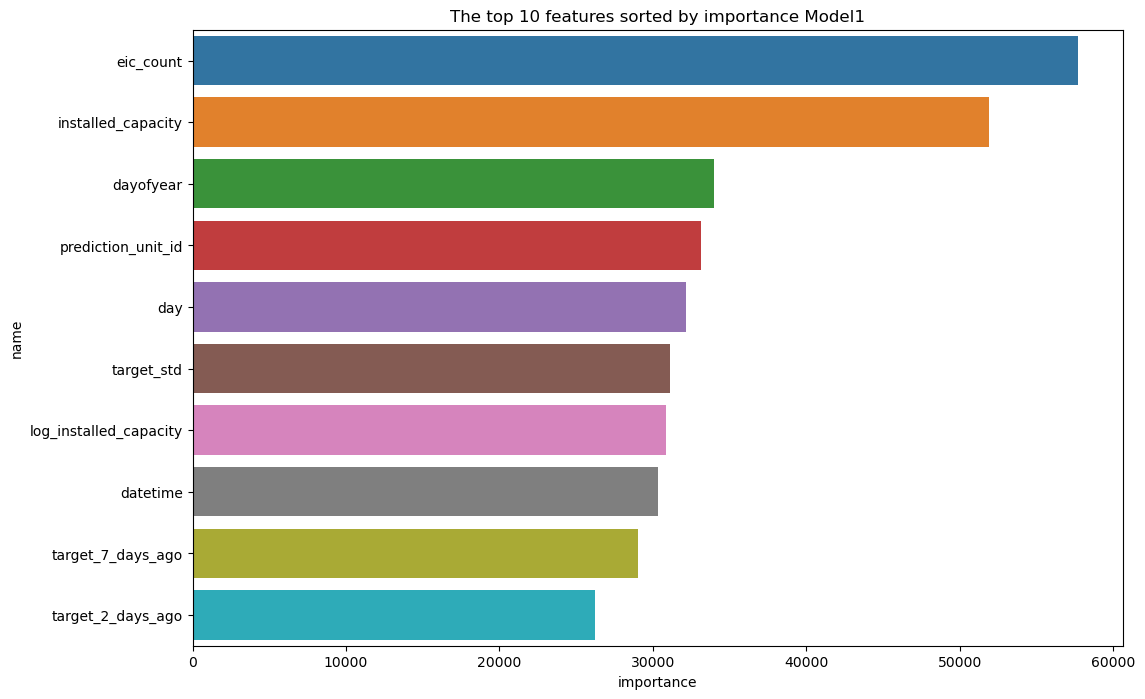

In [24]:
TOP = 10
importance_data = pd.DataFrame({'name': train.drop('target', axis= 1).columns
, 'importance': lgbm.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
#patches = ax.patches
#count = 0
#for patch in patches:
    #height = patch.get_height() 
    #width = patch.get_width()
    #perc = 0.01*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    #ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    #count+=1
    
plt.title(f'The top {TOP} features sorted by importance Model1')
plt.show()

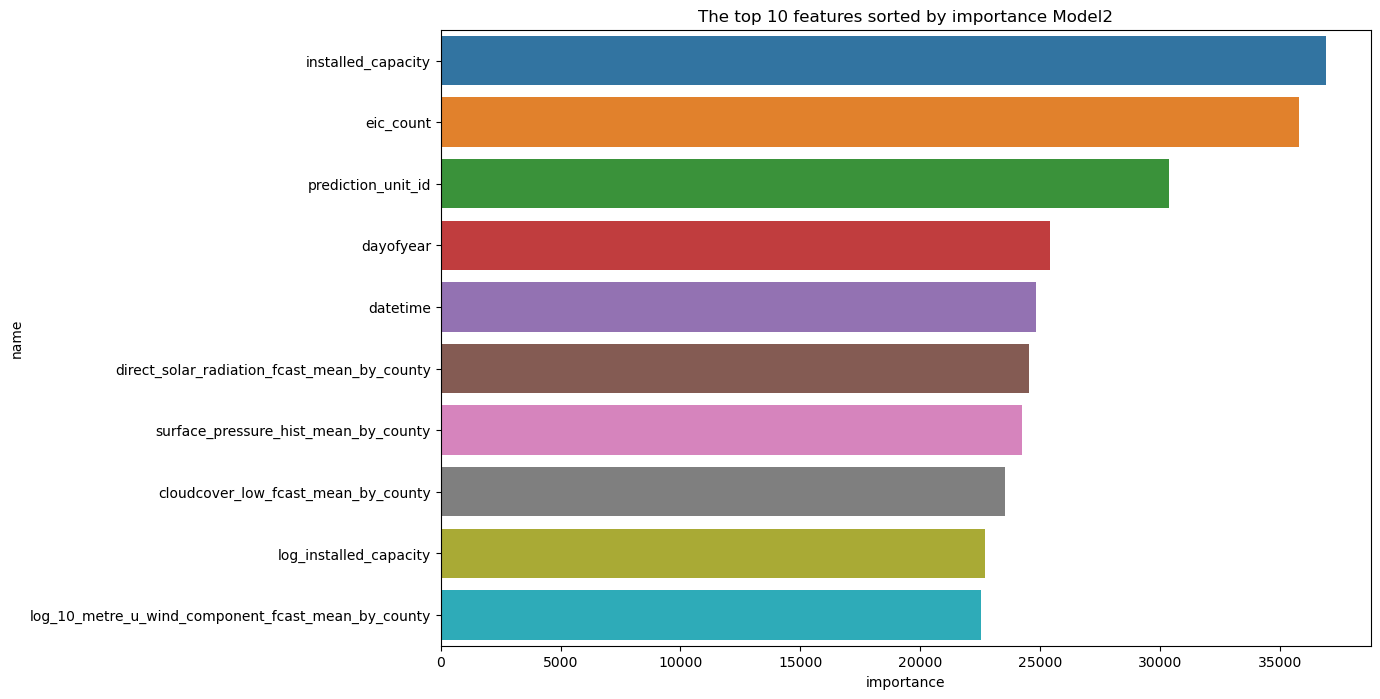

In [28]:
TOP = 10
importance_data = pd.DataFrame({'name': train.drop('target', axis= 1).columns
, 'importance': lgbm2.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
#patches = ax.patches
#count = 0
#for patch in patches:
    #height = patch.get_height() 
    #width = patch.get_width()
    #perc = 0.01*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    #ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    #count+=1
    
plt.title(f'The top {TOP} features sorted by importance Model2')
plt.show()

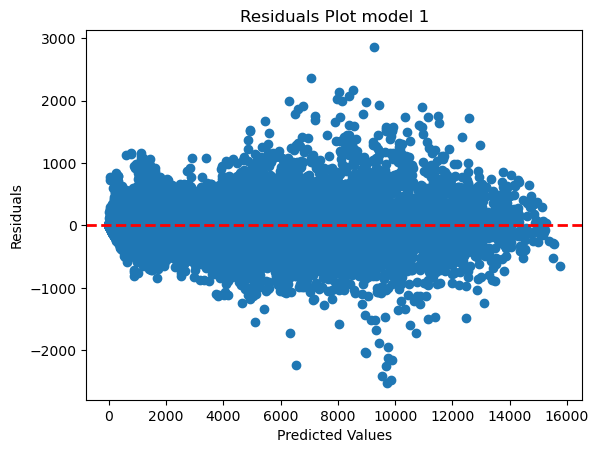

In [29]:
residuals = Yvl - predictions

plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot model 1')
plt.show()


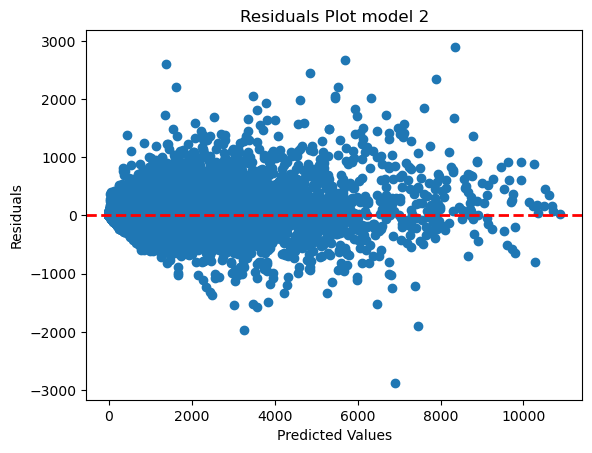

In [30]:
residuals1 = Yvl1 - predictions1

plt.scatter(predictions1, residuals1)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot model 2')
plt.show()

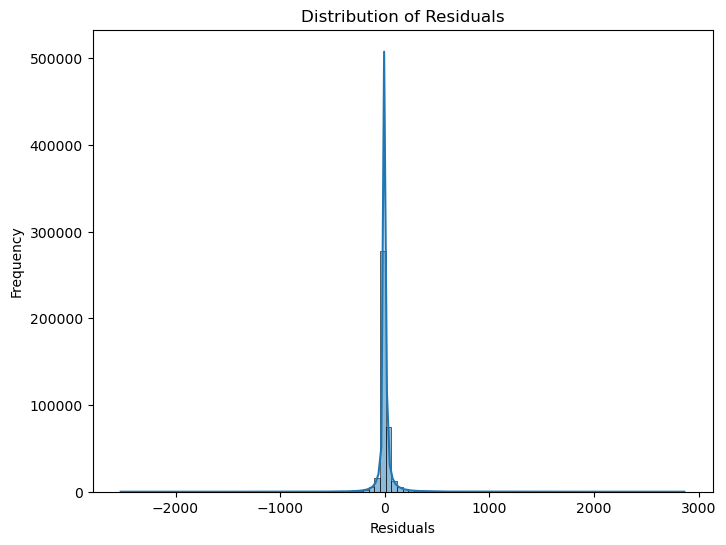

In [31]:
import seaborn as sns

# Adjust the figure size
plt.figure(figsize=(8, 6))

# Increase the number of bins for more granularity
sns.histplot(residuals, kde=True, bins=100)  

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()


It shows the distribution of residuals, which are differences between observed and predicted values in a dataset. In this case, the residuals are heavily centered around zero, indicating that the predictions are generally accurate and errors are minimal. The distribution is highly peaked at 0 residual, indicating most predicted values closely match the observed values. There’s minimal spread of residuals on either side of 0, showing low variance in prediction errors.

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions on the validation set
y_pred = lgbm.predict(Xvl)
y_pred2 = lgbm2.predict(Xvl1)

# Evaluate model 1
mae1 = mean_absolute_error(Yvl, y_pred)
mse1 = mean_squared_error(Yvl, y_pred)
r2_1 = r2_score(Yvl, y_pred)

# Evaluate model 2
mae2 = mean_absolute_error(Yvl1, y_pred2)
mse2 = mean_squared_error(Yvl1, y_pred2)
r2_2 = r2_score(Yvl1, y_pred2)

print("Model 1 Metrics:")
print(f"MAE: {mae1}")
print(f"MSE: {mse1}")
print(f"R-squared: {r2_1}")
print("\nModel 2 Metrics:")
print(f"MAE: {mae2}")
print(f"MSE: {mse2}")
print(f"R-squared: {r2_2}")


Model 1 Metrics:
MAE: 28.750164654265806
MSE: 6292.013407963262
R-squared: 0.9956398341205936

Model 2 Metrics:
MAE: 11.909942314024265
MSE: 2850.0998102099725
R-squared: 0.980358879374932


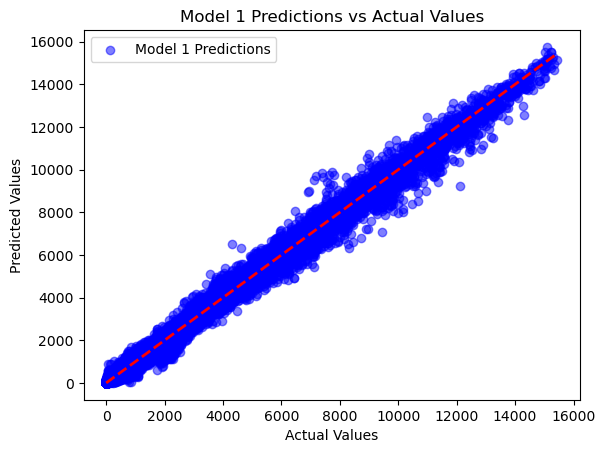

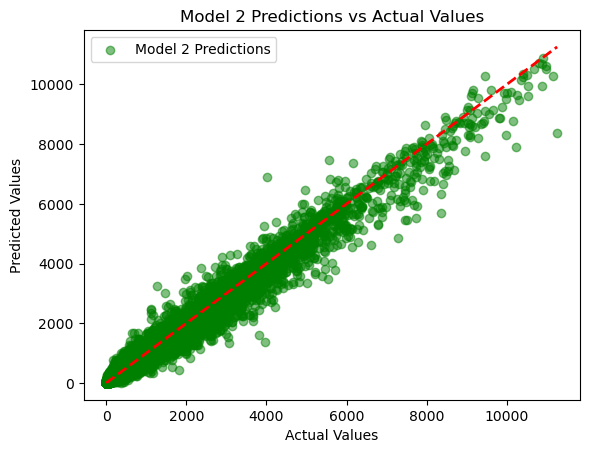

In [33]:
# Scatter plot with lines for Model 1
plt.scatter(Yvl, y_pred, label='Model 1 Predictions', alpha=0.5, color='blue')
plt.plot([min(Yvl), max(Yvl)], [min(Yvl), max(Yvl)], '--', color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model 1 Predictions vs Actual Values')
plt.legend()
plt.show()

# Scatter plot with lines for Model 2
plt.scatter(Yvl1, y_pred2, label='Model 2 Predictions', alpha=0.5, color='green')
plt.plot([min(Yvl1), max(Yvl1)], [min(Yvl1), max(Yvl1)], '--', color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model 2 Predictions vs Actual Values')
plt.legend()
plt.show()
